In [2]:
# enables autoreloading modules
# means that if changes made in referenced .py files, the jupyter nb doesnt need to be restarted
# !! unfortunately: This cell needs to be reloaded when changes made to the bootstrap in bootstrap.py (still better than restarting)
%load_ext autoreload
%autoreload 2

# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from bootstrap import Bootstrap, MonteCarlo

# Synthetic Data Example (Franke & Halim, 2007)

No Defects: $H_0: m_I = m_{II}$

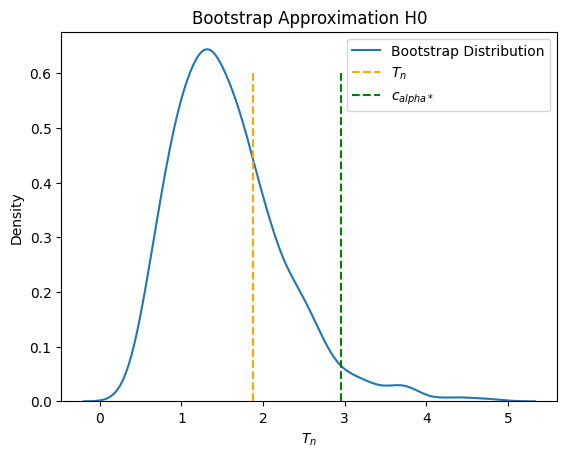

In [238]:
# Generate observational data
y1, y2 = generate_data_franke(defect=False)
BS = Bootstrap(method="wild", kernel_function="bartlett_priestley_kernel")
results_H0 = BS.compute(y1, y2, h=.07, g=.08, B=1000, B_std=25, alpha=np.linspace(0.01, 1, 100), beta=0.95, printout=False)
BS.plot_kde(title="Bootstrap Approximation H0")
result = results_H0["rejected_0.05000"]

In [ ]:
print(np.sum(np.array(result) == False) / 50)

0.88


100%|██████████| 1000/1000 [00:04<00:00, 209.01it/s]


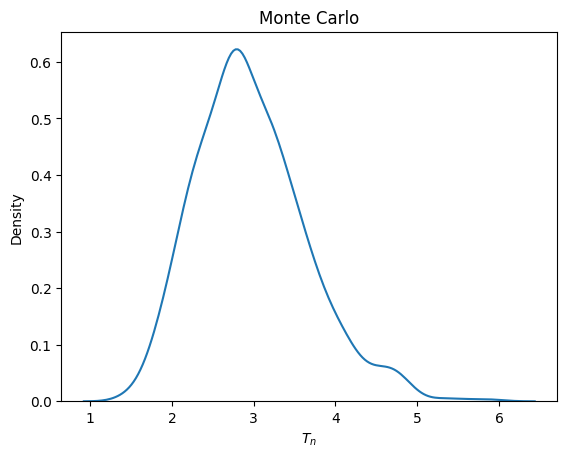

In [7]:
MC = MonteCarlo(kernel_function="bartlett_priestley_kernel")
Tn_monte = MC.compute_Tn(h=.02, M=1000)

# run & plot
fig, ax = plt.subplots()
sns.kdeplot(Tn_monte, ax=ax)
ax.set_xlabel(r"$T_n$")
ax.set_title("Monte Carlo")
plt.show()

Defects: $H_1: m_I$ != $m_{II}$

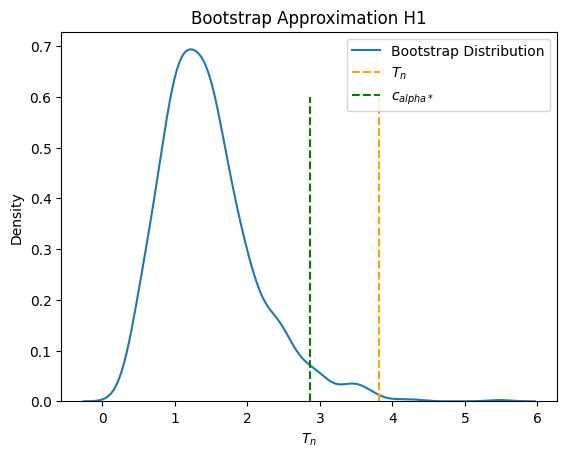

In [240]:
# Generate observational data
y1, y2 = generate_data_franke(defect=True)

BS = Bootstrap(method="wild", kernel_function="bartlett_priestley_kernel")
results_H1 = BS.compute(y1, y2, h=.07, g=.08, B=1000, B_std=25, alpha=np.linspace(0.01, 1, 100), beta=0.95, printout=False)
BS.plot_kde(title="Bootstrap Approximation H1")

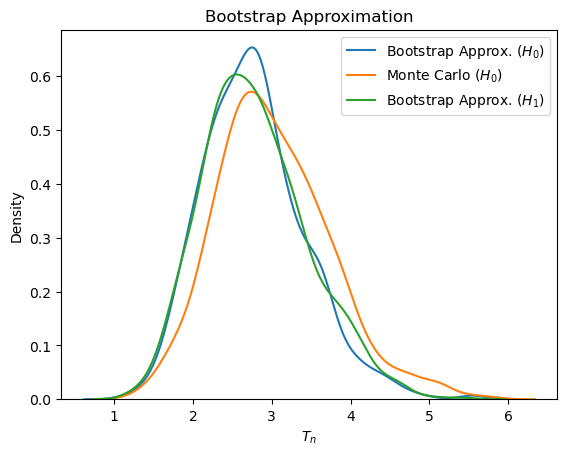

In [5]:
fig, ax = plt.subplots()
sns.kdeplot(results_H0["Tn_star"], ax=ax, label=r"Bootstrap Approx. ($H_0$)")
sns.kdeplot(Tn_monte, ax=ax, label=r"Monte Carlo ($H_0$)")
sns.kdeplot(results_H1["Tn_star"], ax=ax, label=r"Bootstrap Approx. ($H_1$)")
#ax.vlines(results_H0["Tn"], ymin=0, ymax=.6, linestyles="dashed",colors="orange", label=r"$T_n H_0$")
#ax.vlines(results_H1["Tn"], ymin=0, ymax=.6, linestyles="dashed",colors="green", label=r"$T_n H_1$")

#sns.kdeplot(Tn_monte_H1, ax=ax, label=r"Monte Carlo ($H_1$)")
ax.set_xlabel(r"$T_n$")
ax.set_title("Bootstrap Approximation")
ax.legend()
plt.show()

# Examination

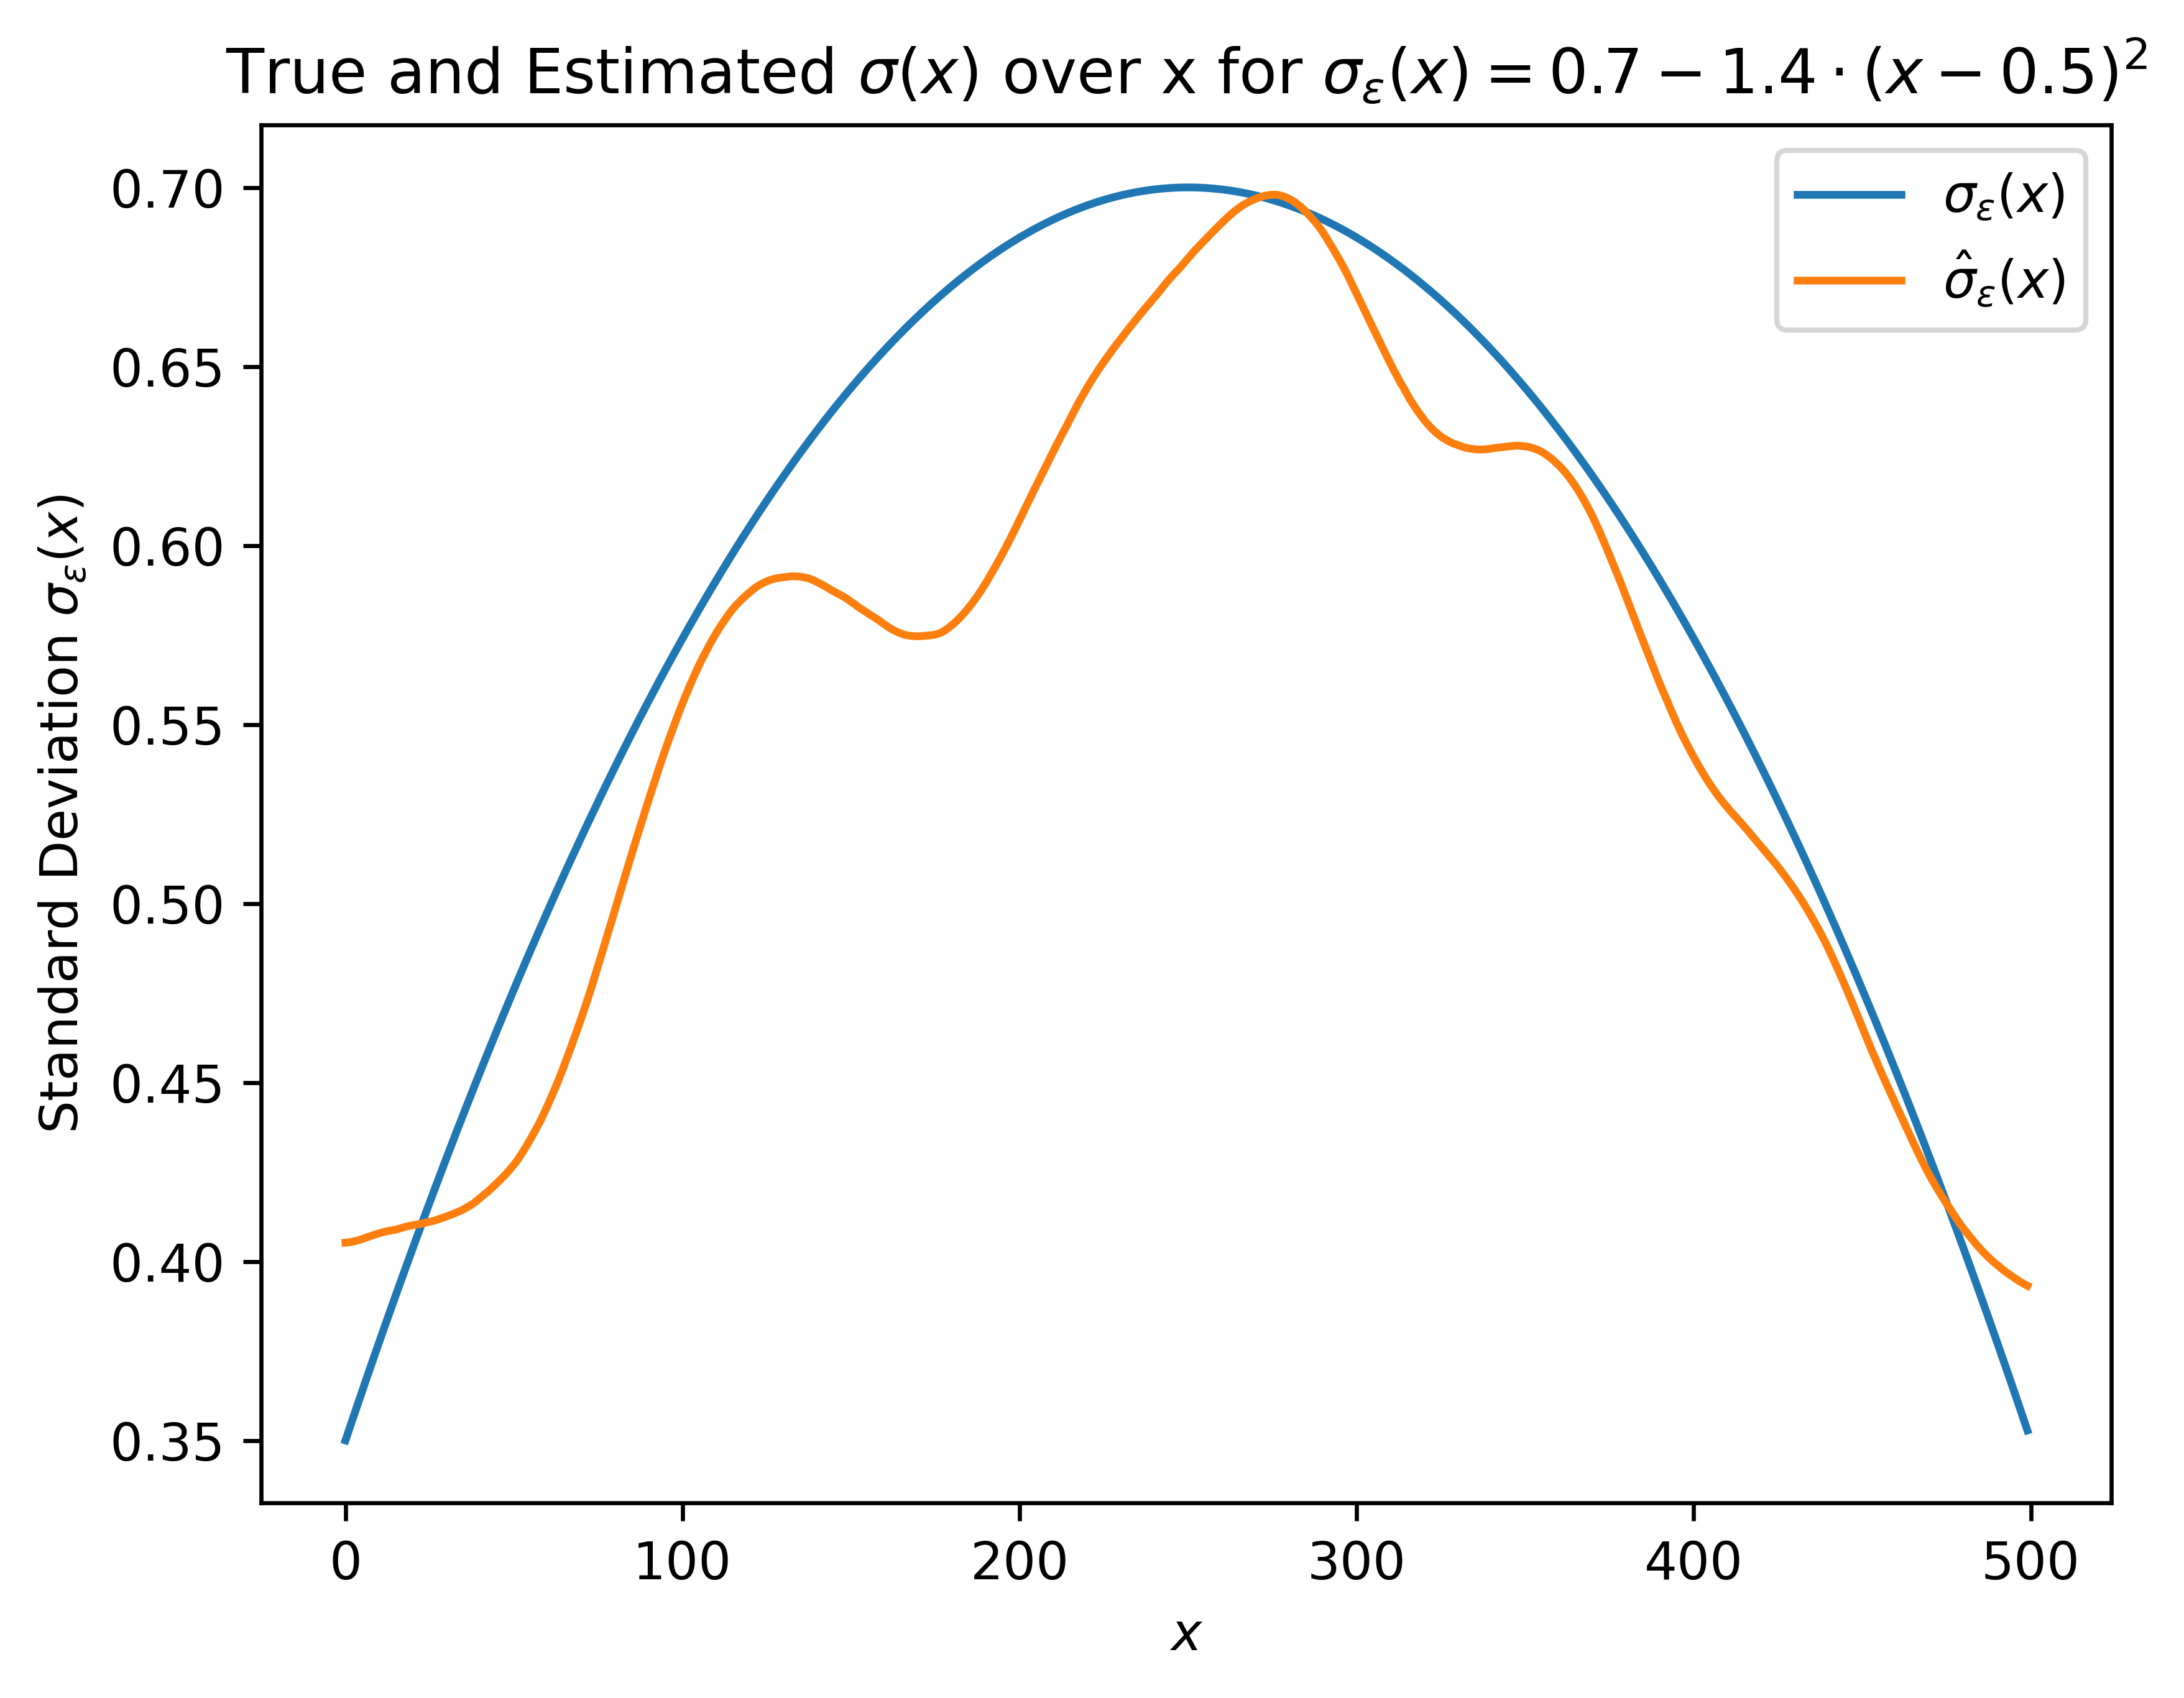

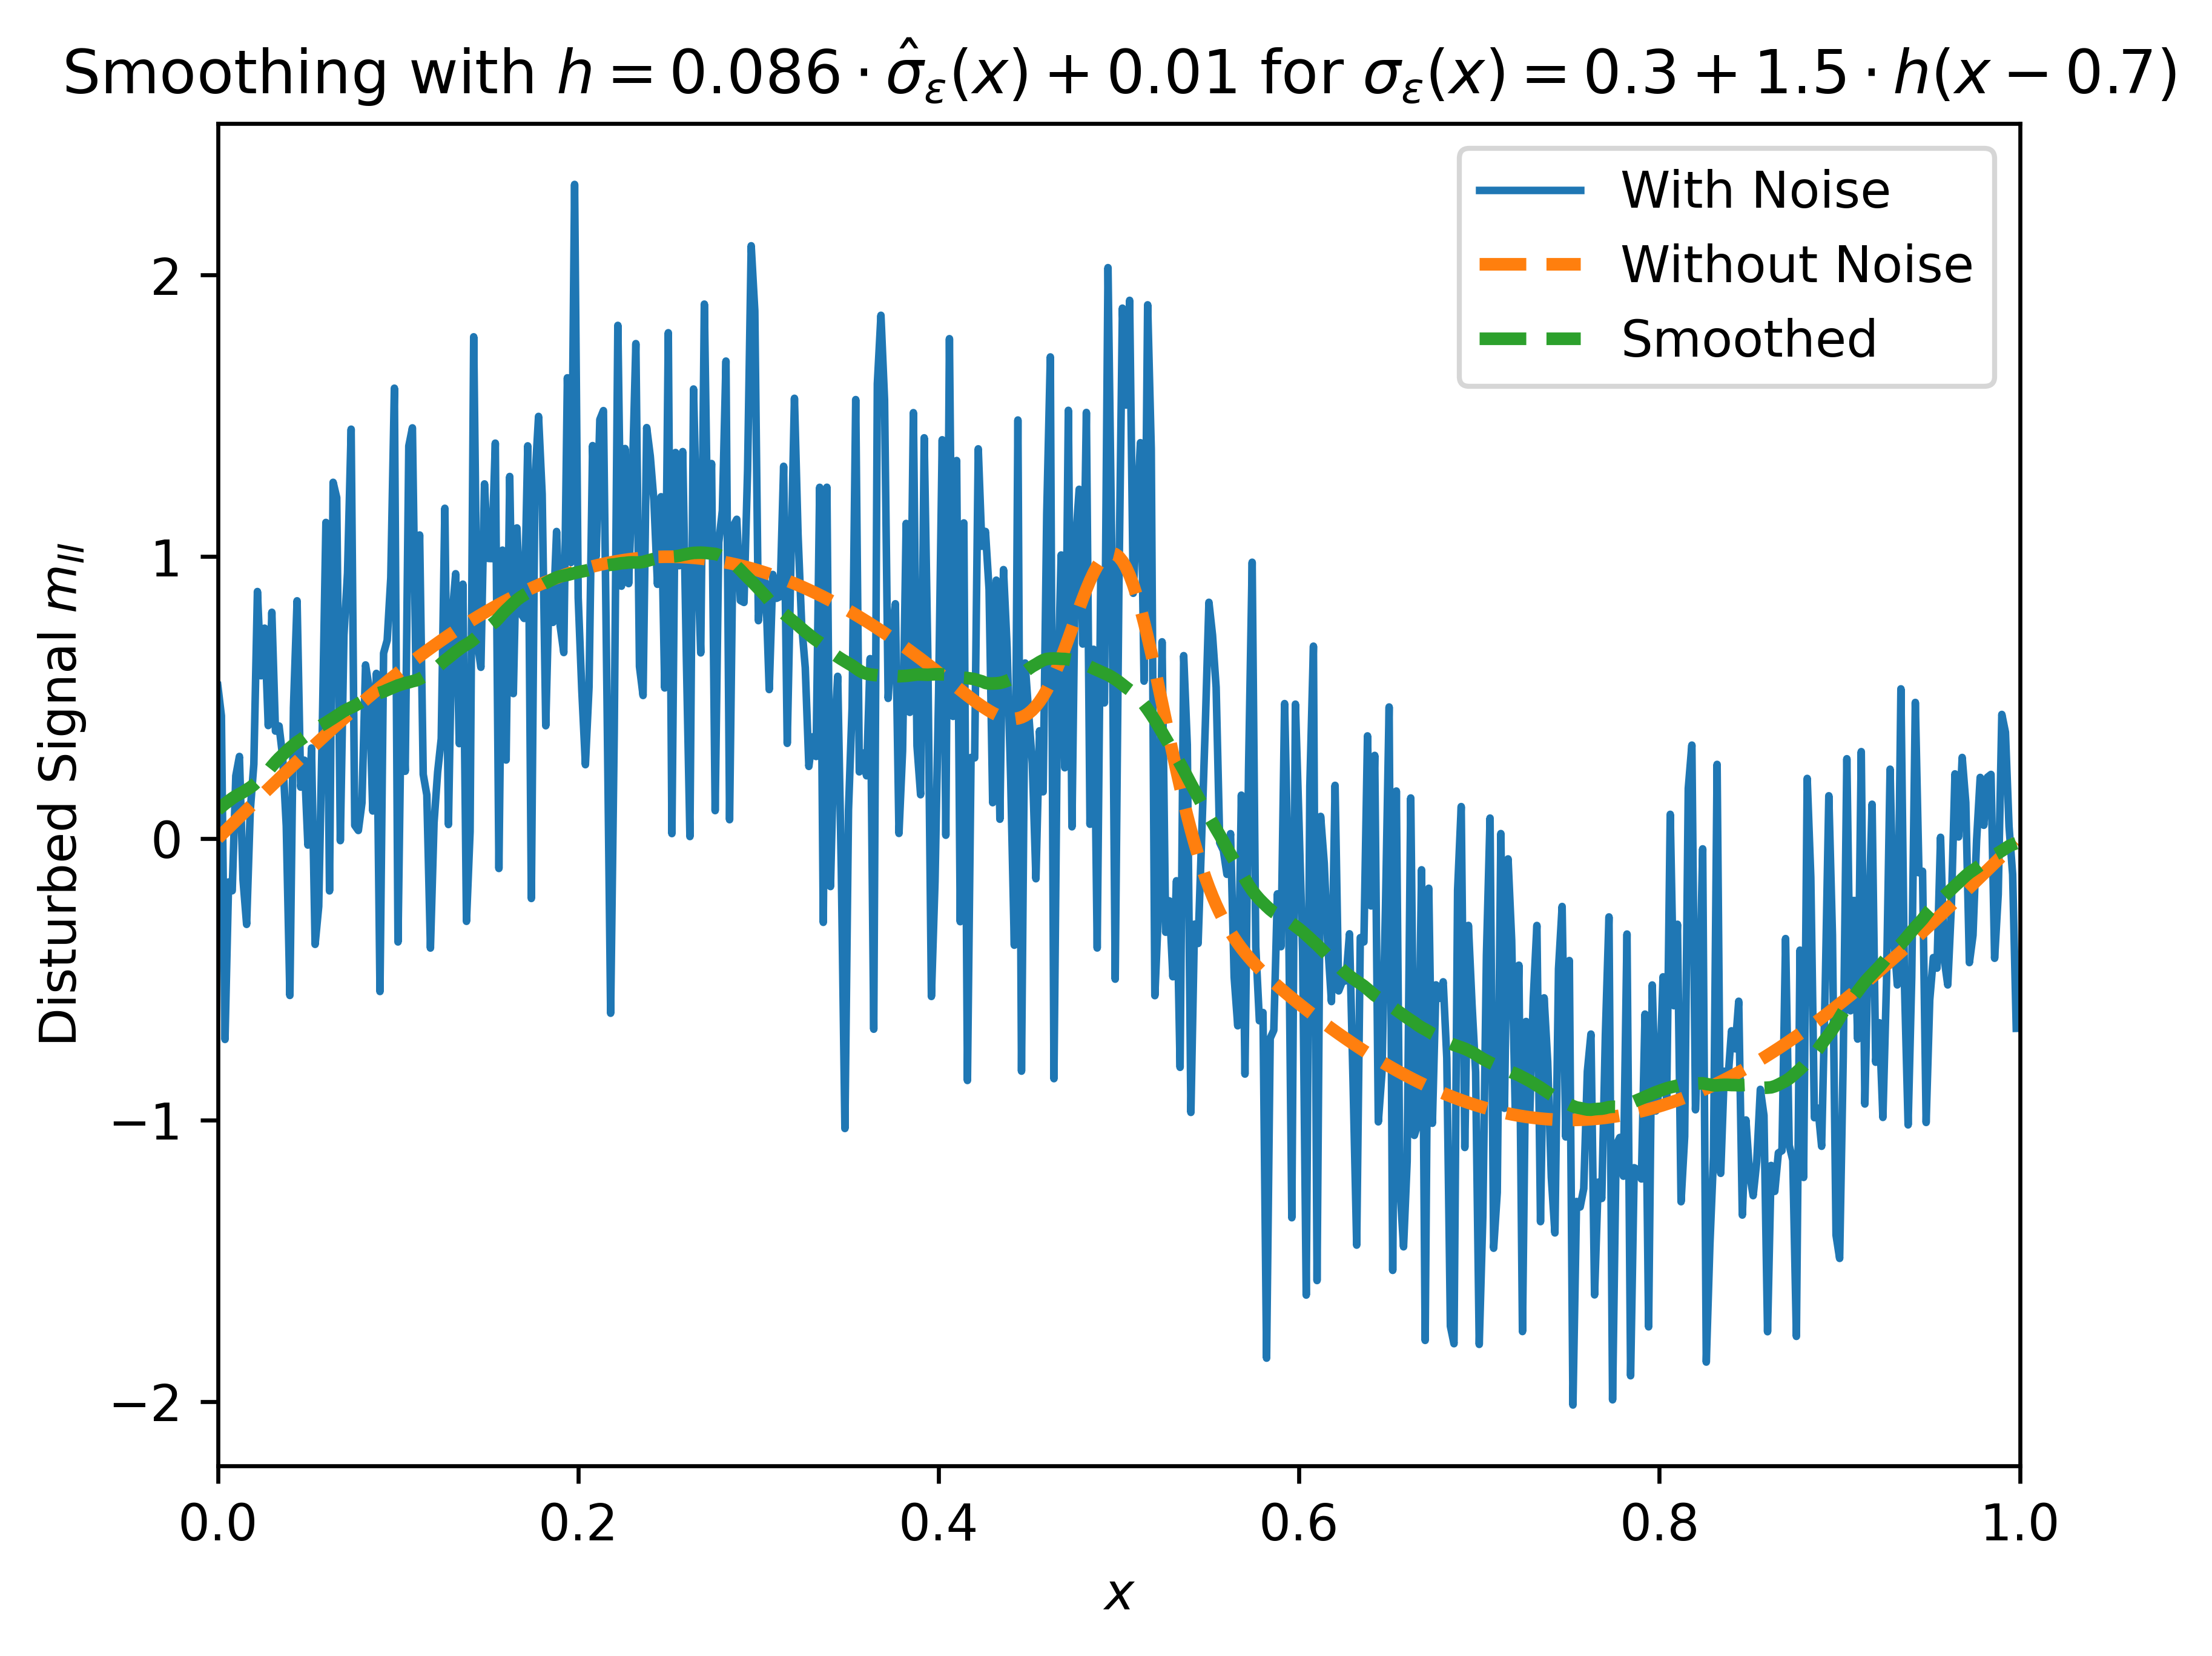

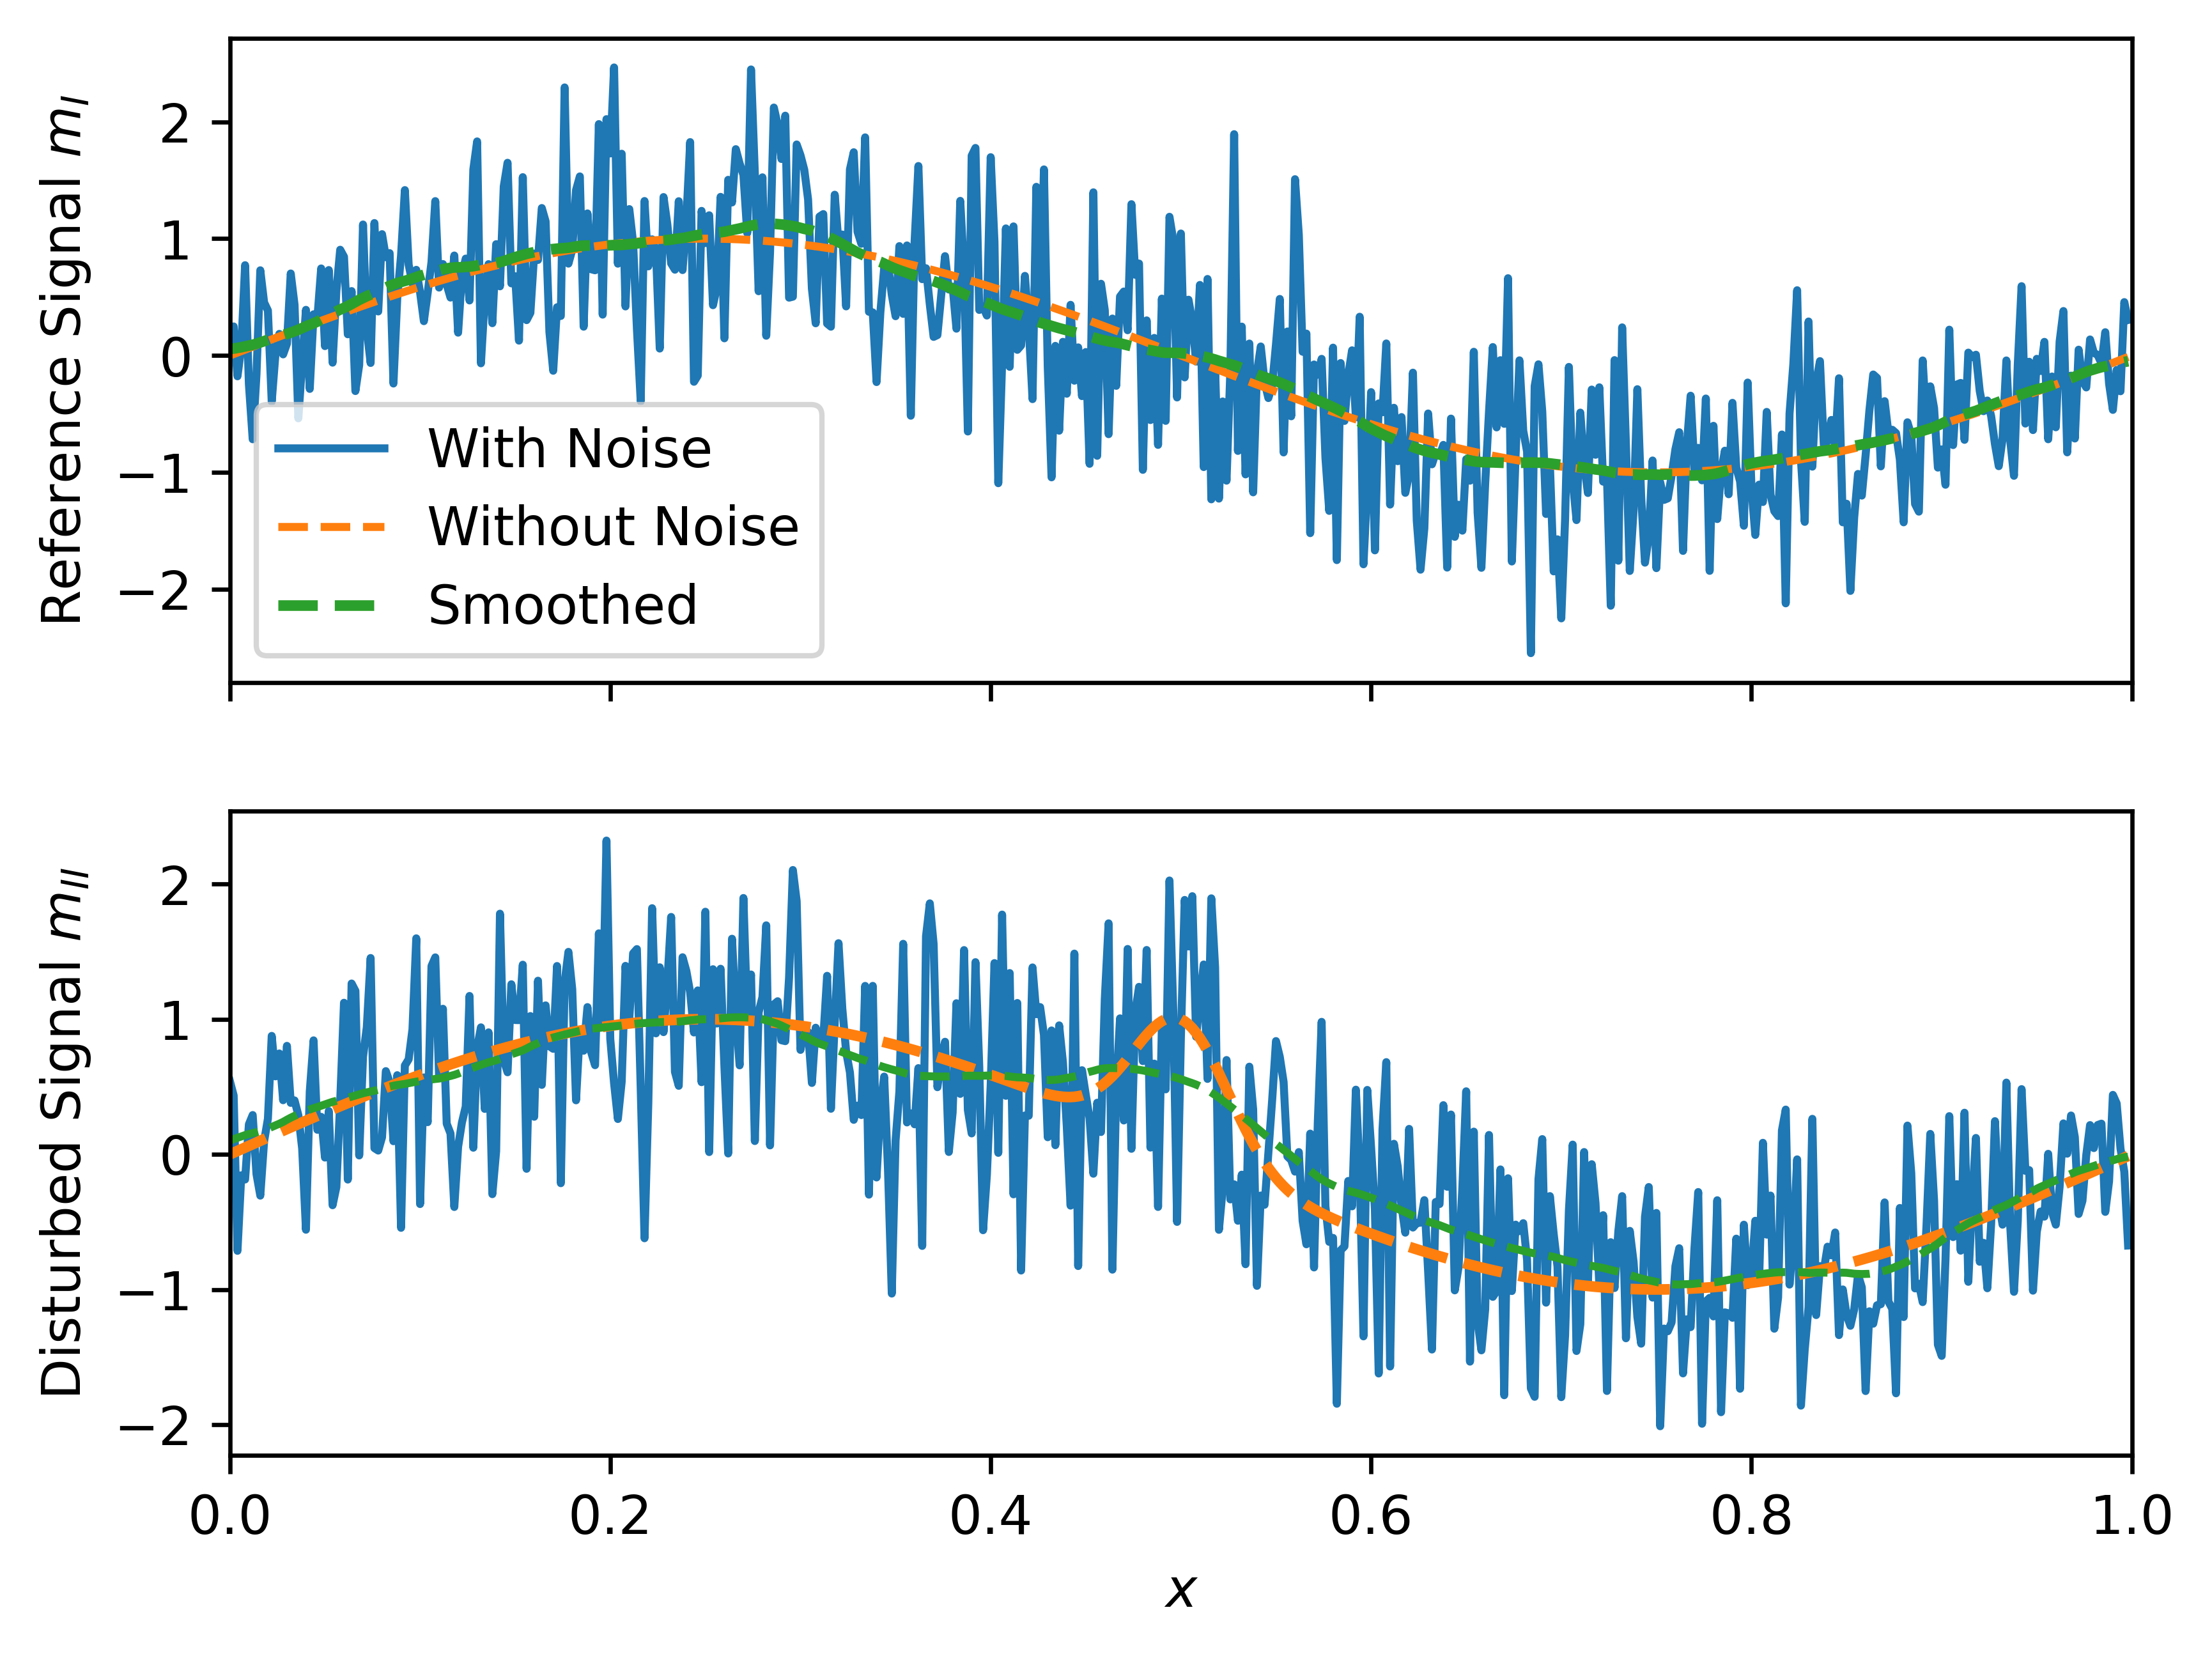

In [411]:
# plotting generated signals
N = 500
x = np.arange(N)/N
m1 = np.sin(np.pi*2*x)
m2 = np.sin(np.pi*2*x) + np.exp((-800)*np.power(x-0.5, 2))
sigma = 0.7 - 1.4*np.square(x-0.5)
#sigma = 0.7 - 8*np.power(x-0.5, 2)*np.sin(np.pi*x)*(np.exp(-(x-0.2)/0.4)+np.exp((x-0.7)/0.4))
#sigma = 0.1+np.power(x, 3)*0.5
#sigma = 0.1 + 2*x + np.power(x, 3)*1.5 # + np.sum([np.exp((-150000)*np.power(x-i, 2)) for i in np.linspace(0.05, 1, 10)], axis=0) #
#sigma = 0.5 + 2.5*np.sum([np.exp((-1000)*np.power(x-i, 2)) for i in np.linspace(0.05, 1, 5)], axis=0)
#sigma = 0.3 + (x>0.7).astype(float)*0.7
#sigma = 0.7 - 1.4*np.square(x-0.5)

y1, y2 = generate_synthetic_data(m1, m2, sigma)
y1_clean, y2_clean = generate_synthetic_data(m1, m2, 0)

h = 0.02

m1 = calc_smoothed_estimate_parallel(y1, bartlett_priestley_kernel, h)
m2 = calc_smoothed_estimate_parallel(y2, bartlett_priestley_kernel, h)

eps1 = y1 - m1 
std = np.zeros_like(eps1)
N = eps1.shape[0]
for i in range(N):
    data = eps1[max(0,i-N//10):i+N//10]
    mean = np.average(data, weights=np.hamming(data.shape[0]))
    if(i > 0):
        #std[i] = 0.95*std[i-1]+0.05*np.std(data*np.hamming(data.shape[0]) * (data.shape[0]-1) / np.sum(np.hamming(data.shape[0])), ddof=1)
        std[i] = 0.95*std[i-1] + 0.05*np.sqrt(np.average(np.square(data-mean), weights=np.hamming(data.shape[0])))
    else:
        #std[i] = np.std(data*np.hamming(data.shape[0]) * (data.shape[0]-1) / np.sum(np.hamming(data.shape[0])), ddof=1)
        std[i] = np.sqrt(np.average(np.square(data-mean), weights=np.hamming(data.shape[0])))

h = 0.086 * std + 0.01 # Approximate formula for h based on std estimate : h = ((0.15 - 0.02) / (1.8-0.3)) * std + 0.01

m1 = calc_smoothed_estimate_parallel(y1, bartlett_priestley_kernel, h)
m2 = calc_smoothed_estimate_parallel(y2, bartlett_priestley_kernel, h)

plt.figure(dpi=600)
plt.plot(x, sigma)
plt.plot(x, std)
plt.legend([r"$\sigma_{\epsilon}(x)$", r"$\hat{\sigma}_{\epsilon}(x)$"])
plt.xlabel(r"$x$")
plt.ylabel(r"Standard Deviation $\sigma_{\epsilon}(x)$")
plt.title(r"True and Estimated $\sigma(x)$ over x for $\sigma_{\epsilon}(x) = 0.7 - 1.4 \cdot (x-0.5)^2$")
plt.show()

plt.figure(dpi=600)
plt.plot(x, y2)
plt.plot(x, y2_clean, "--", linewidth=2.5)
plt.plot(x, m2, "--", linewidth=2.5)
plt.ylabel(r"Disturbed Signal $m_{II}$")
plt.xlabel(r"$x$")
plt.legend(["With Noise", "Without Noise", "Smoothed"])
plt.title(r"Smoothing with $h=0.086 \cdot \hat{\sigma}_{\epsilon}(x) + 0.01$ for $\sigma_{\epsilon}(x) = 0.3 + 1.5 \cdot h(x-0.7)$") # 0.3 + 1.5 \cdot h(x-0.7) 0.7 - 1.4 \cdot (x-0.5)^2 0.086 \cdot \hat{\sigma}_{\epsilon}(x) + 0.01
plt.xlim([0, 1])
plt.show()

fig, axs = plt.subplots(2,1, sharex=True, dpi=600)
axs[0].plot(x, y1)
axs[0].plot(x, y1_clean, "--")
axs[0].plot(x, m1, "--", linewidth=2)
axs[0].set_ylabel(r"Reference Signal $m_I$")
axs[1].plot(x, y2)
axs[1].plot(x, y2_clean, "--", linewidth=2)
axs[1].plot(x, m2, "--")
axs[1].set_ylabel(r"Disturbed Signal $m_{II}$")
axs[1].set_xlabel(r"$x$")
axs[0].legend(["With Noise", "Without Noise", "Smoothed"])
plt.xlim([0, 1])
plt.show()

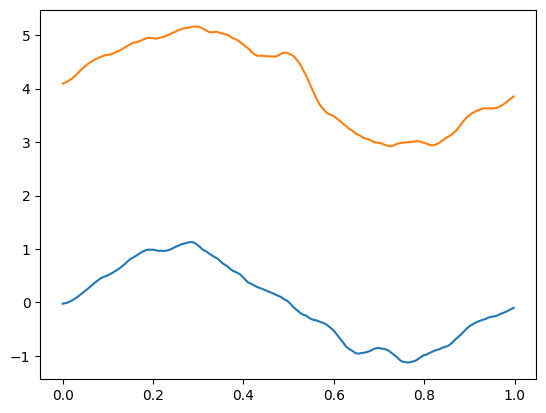

In [87]:
# plotting smoothed estimates
m1 = calc_smoothed_estimate(y1, bartlett_priestley_kernel, h=0.05)
m2 = calc_smoothed_estimate(y2, bartlett_priestley_kernel, h=0.05)
plt.plot(x, m1)
plt.plot(x, m2+4)
# plt.plot(x,np.square(m1-m2))
# np.sum(np.square(m1-m2))*np.sqrt(0.02)
plt.show()

# Test 2D Image

In [160]:
folders = ["no_defect_images", "defect_images"]
X,X_hat = load_images(folders, target_size=(100, 100), detrend=False)
y = X_hat[1]

Processing Rows: 5it [00:00, 49.10it/s]

Processing Rows: 100it [00:00, 179.56it/s]
Processing Columns: 100it [00:00, 196.05it/s]


[False False False False False False False False False False False False
 False False False False False False False False False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False] [False False False False False False False False False False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False 

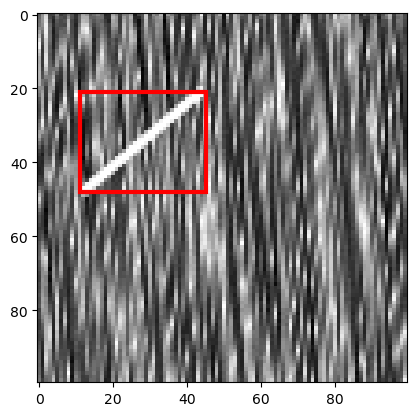

In [163]:
# h_r = 0.005 h_c = 0.01 kernel_function="gaussian_kernel"

h_r = 0.005
h_c = 0.01
factor = 10
BS = Bootstrap(method="wild", kernel_function="gaussian_kernel")
defect, minpoint, maxpoint = BS.test_image(X[0],y, B=500, h=(h_r, h_c), g=(h_r*factor, h_c*factor))
print(defect, minpoint, maxpoint)
plot_defect_area(y, minpoint, maxpoint)

# Old Snippets

In [ ]:
epsilon_hat = np.random.random_sample(10)
x_all = np.zeros((1000000, 10))
for i in range(1000000):
    x_all[i, :] = get_wild_residual_normal(epsilon_hat)
print(np.square(epsilon_hat))
print(np.power(epsilon_hat, 3))
print(np.mean(x_all, axis=0))
print(np.mean(np.square(x_all), axis=0))
print(np.mean(np.power(x_all, 3), axis=0))

In [ ]:
import matplotlib.pyplot as plt 
N = 500
x = np.arange(N)/N
y = np.sin(np.pi * 2* x) + np.exp((-800)*np.power(x-0.5, 2))
m = smoothed_estimate(y, bartlett_priestley_kernel, h=0.2)

plt.figure(dpi=600)
plt.plot(x, y)
plt.plot(x, m)
plt.title("Test for smoothed estimate")
plt.legend(["y", "m"])
plt.show()